Ray rllib installation

In [1]:
!pip install -U "ray[rllib]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00


Google colab mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/rllib')

Import libraries

In [4]:
import pickle
import numpy as np
import random
from scipy import odr
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import NormalizeObservation
from gymnasium.wrappers import NormalizeReward

import os
import ray
from ray import train, tune, air
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune import ResultGrid
from ray.tune.logger import pretty_print
from ray.tune.registry import get_trainable_cls
from ray.tune.registry import register_env

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


Config

In [5]:
import easydict

args = easydict.EasyDict({
    'run': 'PPO',
    'stop_iters': 200,
    'stop_timesteps': 100000,
    'stop_reward': 30,
    'no_tune': False,
    'framework': 'torch'
})

In [6]:
version = 'baseline'
base_tmp_folder = './result'
direcrory = base_tmp_folder+'/models/'
model_dir = direcrory + version
model_path = model_dir + '/model/'
scaler_dir = model_dir + '/scaler/'

env_config = easydict.EasyDict({
    'model1_dir': model_path+'simulator_greenhouse.pkl',
    'model2_dir': model_path+'simulator_crop_front.pkl',
    'model3_dir': model_path+'simulator_crop_back.pkl',
    'scaler1_x': scaler_dir+'greenhouse_x_scaler.pkl',
    'scaler1_y': scaler_dir+'greenhouse_y_scaler.pkl',
    'scaler2_x': scaler_dir+'crop_front_x_scaler.pkl',
    'scaler2_y': scaler_dir+'crop_front_y_scaler.pkl',
    'scaler3_x': scaler_dir+'crop_back_x_scaler.pkl',
    'scaler3_y': scaler_dir+'crop_back_y_scaler.pkl',
    'linreg_dir': model_path+'PARsensor_regression_parameters.pkl',
    'weather_dir': model_path+'weather.npy'
})

Net

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=120):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

Economic model

In [8]:
class Economic:
    def __init__(self, dayAction, dayState, dayReward):
        self.dayAction = dayAction  # [heating temp, ventilation, lamps, scr_enrg, scr_blck, co2]
        self.dayState = dayState  # [AirT, AirRH, Airppm]
        self.dayReward = dayReward  # [FW]

    def cal_economic(self):

        gains = self.cal_gains()
        elecCost = self.elec_cost()
        co2Cost = self.co2_cost()
        heatCost = self.heat_cost()

        variableCosts = elecCost + co2Cost + heatCost
        balance = gains - variableCosts
        # balance = gains

        economic = {'balance': balance,
                    'gains': gains,
                    'variableCosts': variableCosts,
                    'elecCost': elecCost,
                    'co2Cost': co2Cost,
                    'heatCost': heatCost}

        return economic

    def cal_gains(self):
        # price = 3.5
        price = 3.185
        # price = 3.1
        # price = 2.94
        return self.dayReward[0] * price

    def elec_cost(self):
        lmp_use = self.dayAction[:, 2]
        days = len(lmp_use) // 24

        power = 185 / 2.1

        price = np.array(([0.04] * 7 + [0.08] * 16 + [0.04] * 1) * days)
        cost = np.sum(np.array(lmp_use) * price * power / 1000)

        return cost

    def co2_cost(self):
        CO2_setpoint = self.dayAction[:, 5]
        Airppm = self.dayState[:, 2]

        McConAir_max = 4e-6
        co2_use = CO2_setpoint - Airppm
        co2_use[co2_use > 0] = McConAir_max
        co2_use[co2_use <= 0] = 0

        price1, price2 = 0.08, 0.2
        kgCO2 = sum(co2_use) * 3600
        firstTranche = min(kgCO2, 12)
        secondTranche = kgCO2 - firstTranche
        cost = firstTranche * price1 + secondTranche * price2

        return cost

    def heat_cost(self):
        temp_setpoint = self.dayAction[:, 0]
        AirT = self.dayState[:, 0]

        PConPipe1_max = np.full((24), 60)
        heat_use = (PConPipe1_max - AirT) * 2.1

        heat = temp_setpoint - AirT
        heat_use[heat <= 0] = 0

        price = 0.03
        cost = sum(heat_use) * price / 1000

        return cost

Custom environment

In [9]:
class GreenhouseEnv(gym.Env):

    def __init__(self, config):
        self.net1 = Net(14, 3, 300)
        self.net1.load_state_dict(torch.load(
            config['model1_dir'], map_location=torch.device('cpu')))
        self.net2 = Net(5, 1, 300)
        self.net2.load_state_dict(torch.load(
            config['model2_dir'], map_location=torch.device('cpu')))
        self.net3 = Net(2, 1, 600)
        self.net3.load_state_dict(torch.load(
            config['model3_dir'], map_location=torch.device('cpu')))
        self.net1.eval()
        self.net2.eval()
        self.net3.eval()

        self.scaler1_x = pickle.load(open(config['scaler1_x'], 'rb'))
        self.scaler1_y = pickle.load(open(config['scaler1_y'], 'rb'))
        self.scaler2_x = pickle.load(open(config['scaler2_x'], 'rb'))
        self.scaler2_y = pickle.load(open(config['scaler2_y'], 'rb'))
        self.scaler3_x = pickle.load(open(config['scaler3_x'], 'rb'))
        self.scaler3_y = pickle.load(open(config['scaler3_y'], 'rb'))

        self.linreg = pickle.load(open(config['linreg_dir'], 'rb'))

        self.full_weather = np.load(config['weather_dir'])

        self.observation_space = self.observation_space()
        self.action_space = self.action_space()

        self.reset()

        self._max_episode_steps = 48

    def observation_space(self):
        # AirT * 24, AirRH * 24, Airppm * 24; GR; FW
        low = np.concatenate(([0 for _ in range(24)], [0 for _ in range(24)],
                               [0 for _ in range(24)], [0, 0]))
        high = np.concatenate(([40 for _ in range(24)], [100 for _ in range(24)],
                                [6000 for _ in range(24)], [10, 300]))
        return Box(low=low, high=high, dtype=np.float32)

    def action_space(self):
        # heating temp, ventilation, lamps, scr_enrg, scr_blck, co2
        low = np.concatenate(
            ([0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)],
             [0 for _ in range(24)], [0 for _ in range(24)]))
        high = np.concatenate(
            ([40 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)],
             [1 for _ in range(24)], [6000 for _ in range(24)]))

        return Box(low=low, high=high, dtype=np.float32)

    def f_co2(self, co2):
        beta_co2 = 400
        return 1 - np.exp(-co2 / beta_co2)

    def f_par(self, par):
        beta_par = 200
        return 1 - np.exp(-par / beta_par)

    def f_t(self, t):
        t_opt = 25
        t_diff = np.abs(t - t_opt)
        t_rng = 25
        if t_diff < t_rng:
            return 1 - (t_diff / t_rng) ** 2
        else:
            return 0

    def g(self, co2, par, t, fw, d, h):
        day_fw = fw[d*24:(d+1)*24]
        cum_gr_t = ((day_fw[h] + 1)/(day_fw[0] + 1)) ** (1/(h+1)) - 1
        hour_gr = 1.194 ** (1 / 12)
        max_gr = np.array([hour_gr, cum_gr_t], dtype=object)
        max_gr = np.min(max_gr)
        co2_r = self.f_co2(co2)
        par_r = self.f_par(par)
        t_r = self.f_t(t)
        return max_gr * co2_r * par_r * t_r

    def get_outside_weather(self, day_index):
        if day_index < 48:
            return self.full_weather[day_index * 24:(day_index + 1) * 24]
        else:
            mv_idx = day_index - 48
            return self.full_weather[(day_index - mv_idx) * 24:(day_index + 1-mv_idx) * 24]

    def calculate_reward(self, dayAction, dayState, dayReward):
        economic = Economic(dayAction=dayAction, dayState=dayState,
                            dayReward=dayReward).cal_economic()
        reward = economic['balance']

        return reward, economic

    def crop_weight(self, t):
        cm = 20
        rm = 0.14
        tb = 35.4
        w = cm/rm*np.log(1+np.exp(rm*(t-tb)))
        return w

    def poly_fw(self):
        days = 48
        d = np.array(range(days))

        days_fw = self.crop_weight(d)
        fw_model = odr.polynomial(5)
        FW = odr.Data(d, days_fw)
        odr_fw = odr.ODR(FW, fw_model)
        output = odr_fw.run()  # running ODR fitting
        poly = np.poly1d(output.beta[::-1])
        return poly(np.linspace(0, days, days * 24)).reshape(-1, 1)

    def _get_obs(self):
        observation = np.hstack((self.day_inside_weather, self.crop_state, self.fw))
        return observation

    def step(self, action):
        assert len(action) == 144, 'wrong input control dimension'

        # self.action = action

        action = action.reshape((6, 24)).T

        day_outside_weather = self.get_outside_weather(self.day_index)

        day_inside_weather = np.zeros((24, 3))

        cum_gr = 1  # cumulative growth rate

        days_fw = self.poly_fw()

        for i in range(24):
            # each hour
            # Tout, Rhout, Iglob, Windsp, PARout
            cur_outside_weather = day_outside_weather[i]
            cur_control = action[i]  # temp, vent, lamp, scr_enrg, scr_black, co2
            cur_inside_weather = self.inside_weather  # Tair, Rhair, CO2air
            day_inside_weather[i, :] = cur_inside_weather
            input1 = np.hstack(
                (cur_outside_weather, cur_control, cur_inside_weather))
            input1 = input1.reshape(1, -1)
            # input1 = input1.repeat(5,axis=0)
            input1_normal = self.scaler1_x.transform(input1)
            input1_normal = torch.tensor(input1_normal, dtype=torch.float)
            output1_normal = self.net1(input1_normal).detach().numpy()
            # output1_normal = output1_normal.reshape(1,-1)
            output1 = self.scaler1_y.inverse_transform(output1_normal)[0]
            output1 = np.clip(output1, [0, 0, 0], [40, 100, 6000])
            self.inside_weather = output1

            # PARsensor calculation
            PARsensor = self.linreg.predict(input1[0, [2, 4, 7]].reshape(1, -1))
            PARsensor = PARsensor if PARsensor > 50.0 else 0.0
            # PARsensor = np.array(PARsensor)
            # PARsensor = PARsensor.reshape(1,-1)

            # input2 = np.hstack(
            #     (self.inside_weather, PARsensor, self.crop_state))
            # # print(input2)
            # input2 = input2.reshape(1, -1)
            # input2_normal = self.scaler2_x.fit_transform(input2)
            # input2_normal = torch.tensor(input2_normal, dtype=torch.float)
            # output2_normal = self.net2(input2_normal).detach().numpy()
            # output2 = self.scaler2_y.inverse_transform(output2_normal)[0]

            # output2[-1] = np.maximum(self.crop_state[-1], output2[-1])

            # self.crop_state = output2  # LAI, PlantLoad, NetGrowth
            # print(self.inside_weather)
            # print(self.crop_state)

            gr = self.g(co2=output1[2],
                        par=PARsensor,
                        t=output1[0],
                        fw=days_fw,
                        d=self.day_index,
                        h=i)
            cum_gr *= (1 + gr)

        # input3 = np.concatenate((self.crop_state, self.fw))
        # # print(input3)
        # input3 = input3.reshape(1, -1)
        # input3_normal = self.scaler3_x.transform(input3)
        # input3_normal = torch.tensor(input3_normal, dtype=torch.float)
        # output3_normal = self.net3(input3_normal).detach().numpy()
        # output3 = self.scaler3_y.inverse_transform(output3_normal)[0]
        #
        # cur_fw = self.fw
        #
        # output3 = output3 if output3 > 0.1 else np.array([0])
        # output3 = np.maximum(output3, self.fw)
        # self.fw = output3
        # print('fw', self.fw)

        # day_fw = (self.fw - cur_fw) + self.store_fw
        # harvest = 1e-3
        # if day_fw < harvest:
        #     self.store_fw += self.fw - cur_fw
        #     day_fw = np.zeros(1)
        #
        # else:
        #     self.store_fw = np.zeros(1)

        cur_fw = self.fw.copy()
        self.fw *= cum_gr
        day_fw = self.fw - cur_fw

        reward, economic = self.calculate_reward(
            dayAction=action, dayState=day_inside_weather, dayReward=day_fw)

        self.day_inside_weather = day_inside_weather.T.reshape(1, -1)[0]
        obs = self._get_obs()

        self.day_index += 1

        done = self.day_index >= self._max_episode_steps

        return obs, reward, done, False, economic

    def reset(self, seed=None, options=None):
        random.seed(seed)

        self.inside_weather = np.array([17.27, 61.83, 737.31])
        self.day_inside_weather = np.concatenate((np.random.randint(20, 24, 24),
                                                  np.random.randint(50, 80, 24),
                                                  np.random.randint(600, 800, 24)))

        self.crop_state = np.zeros(1)

        self.fw = np.ones(1)

        self.store_fw = np.zeros(1)

        self.day_index = 0

        observation = self._get_obs()

        return observation, {}

Register the custom env

In [10]:
# Register the custom env
def env_creator(env_config):
    env = GreenhouseEnv(env_config)
    # env = NormalizeObservation(env)
    env = NormalizeReward(env)
    return env

register_env("greenhouse", env_creator)

Ray rllib PPO

In [11]:
storage_path = '/content/drive/MyDrive/Colab Notebooks/rllib/ray_results'

if not os.path.exists(storage_path):
    os.makedirs(storage_path)

# lr=0.0005, entropy_coeff=0.
# exp_name = 'PPO'

# lr=[1e-4, 1e-5, 1e-6], entropy_coeff=0.
# exp_name = 'PPO2'

# lr=[1e-4, 1e-5, 1e-6], entropy_coeff=0.1
# exp_name = 'PPO2_entr_0_1'

# lr=[1e-4, 1e-5, 1e-6], entropy_coeff=0.01
# exp_name = 'PPO2_entr_0_01'

# lr=lr=[1e-2, 1e-3, 1e-4], entropy_coeff=0.1
# exp_name = 'PPO3_entr_0_1'

# lr=0.0001, entropy_coeff=0.1, num_iters=500
# exp_name = 'PPO_e_500'

# lr=0.0001, entropy_coeff=0.1, num_iters=200, lr_schedule=[[200000, 0.0001], [400000, 0.0001]]
# exp_name = 'PPO_e_200'

# lr=0.0005, entropy_coeff=0.1
exp_name = 'PPO_lr_0_0005'

In [12]:
ray.init()

config = (
        get_trainable_cls(args.run)
        .get_default_config()
        # or "corridor" if registered above
        .environment("greenhouse", env_config=env_config)
        # .environment(GreenhouseEnv, env_config=env_config)
        .framework(args.framework)
        .training(entropy_coeff=0.1,
                  lr=0.0005
                  )
        .rollouts(num_rollout_workers=1,
                  observation_filter='MeanStdFilter')
        # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.
        .resources(num_gpus=int(os.environ.get("RLLIB_NUM_GPUS", "0")))
    )

stop = {
    'training_iteration': args.stop_iters,
    # 'timesteps_total': args.stop_timesteps,
    'episode_reward_mean': args.stop_reward
}

if args.no_tune:
    # manual training with train loop using PPO and fixed learning rate
    print("Running manual train loop without Ray Tune.")
    config.lr = 1e-3
    algo = config.build()
    # run manual training loop and print results after each iteration
    for _ in range(stop['training_iteration']):
        result = algo.train()
        print(pretty_print(result))
        # stop training of the target train steps or reward are reached
        if (
            result['timesteps_total'] >= stop['timesteps_total']
            or result['episode_reward_mean'] >= stop['episode_reward_mean']
        ):
            break
    algo.stop()
else:
    # automated run with Tune and grid search and TensorBoard
    print("Training automatically with Ray Tune")
    tuner = tune.Tuner(
        args.run,
        param_space=config.to_dict(),
        run_config=train.RunConfig(
            name=exp_name,
            stop=stop,
            checkpoint_config=train.CheckpointConfig(
                checkpoint_score_attribute='episode_reward_mean',
                num_to_keep=5
            ),
            storage_path=storage_path
        )
    )
    results_grid: ResultGrid = tuner.fit()

2024-02-09 01:06:38,895	INFO worker.py:1724 -- Started a local Ray instance.
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
2024-02-09 01:06:42,273	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information,

Training automatically with Ray Tune
+--------------------------------------------------------+
| Configuration for experiment     PPO_lr_0_0005         |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 1                     |
+--------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_lr_0_0005
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/PPO_lr_0_0005`

Trial status: 1 PENDING
Current time: 2024-02-09 01:06:42. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| PPO_greenhouse_7c78d_00000   PENDING  |
+---------------------------------------+


(pid=1043) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
(pid=1043)   warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
(pid=1043) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
(pid=1043) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
(pid=1043)   declare_namespace(pkg)
(pid=1043) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
(pid=1043) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/refe


Trial PPO_greenhouse_7c78d_00000 started with configuration:
+---------------------------------------------------------------------------+
| Trial PPO_greenhouse_7c78d_00000 config                                   |
+---------------------------------------------------------------------------+
| _AlgorithmConfig__prior_exploration_config                                |
| _disable_action_flattening                                          False |
| _disable_execution_plan_api                                          True |
| _disable_initialize_loss_from_dummy_batch                           False |
| _disable_preprocessor_api                                           False |
| _enable_new_api_stack                                               False |
| _fake_gpus                                                          False |
| _is_atari                                                                 |
| _learner_class                                                            |
| 

(PPO pid=1043) Trainable.setup took 16.797 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=1043) Install gputil for GPU system monitoring.



Trial status: 1 RUNNING
Current time: 2024-02-09 01:07:12. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| PPO_greenhouse_7c78d_00000   RUNNING  |
+---------------------------------------+
Trial status: 1 RUNNING
Current time: 2024-02-09 01:07:42. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| PPO_greenhouse_7c78d_00000   RUNNING  |
+---------------------------------------+
Trial status: 1 RUNNING
Current time: 2024-02-09 01:08:12. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| PPO_greenhouse_7c78d_00000   RUNNING  |
+-----------------

(PPO pid=1043) 2024-02-09 01:08:53,025	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| PPO_greenhouse_7c78d_00000   RUNNING        34            4135.38   136000    3.58581                4.05824                3.20355                   48                     83 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
Trial status: 1 RUNNING
Current time: 2024-02-09 02:17:20. Total running time: 1hr 10min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward

(PPO pid=1043) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_lr_0_0005/PPO_greenhouse_7c78d_00000_0_2024-02-09_01-06-42/checkpoint_000000)


In [13]:
ray.shutdown()

Load model

In [11]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO2 ...


In [13]:
# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed")
else:
    print("No errors!")

No errors!


In [14]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 3


In [15]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f'Trial #{i} had an error: {result.error}')
        continue

    print(
        f"Trial #{i} finished successfully with a episode reward mean of:",
        result.metrics['episode_reward_mean']
    )

Trial #0 finished successfully with a episode reward mean of: 3.7811839015973643
Trial #1 finished successfully with a episode reward mean of: 3.8190306811098664
Trial #2 finished successfully with a episode reward mean of: 3.7643912494267497


In [16]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "episode_reward_mean"]]

,training_iteration,episode_reward_mean
0,25,3.781184
1,25,3.819031
2,25,3.764391


In [17]:
print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

Shortest training time: 2866.111080646515
Longest training time: 2991.1770997047424


In [18]:
best_result_df = result_grid.get_dataframe(
    filter_metric="episode_reward_mean", filter_mode="max"
)
best_result_df[["training_iteration", "episode_reward_mean"]]

,training_iteration,episode_reward_mean
0,1,3.887456
1,1,3.906535
2,1,3.928493


In [19]:
from ray.train import Result

# Get the result with the maimum test 'mean_accuracy'
best_result: Result = result_grid.get_best_result(
    metric='episode_reward_mean', mode='max'
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = result_grid.get_best_result(
    metric="episode_reward_mean", mode="min"
)

In [24]:
result_df = best_result.metrics_dataframe
result_df[["training_iteration", "episode_reward_mean", "time_total_s"]]

,training_iteration,episode_reward_mean,time_total_s
0,1,3.906535,115.822713
1,2,3.778152,230.569672
2,3,3.780609,346.587229
3,4,3.784555,462.008650
4,5,3.752838,577.136130
5,6,3.766765,691.459130
6,7,3.757632,808.090178
7,8,3.780728,922.944865
8,9,3.778973,1038.607848
9,10,3.790825,1153.163655


entropy_coeff=0, lr=[1e-4, 1e-5, 1e-6]

<Axes: xlabel='training_iteration'>

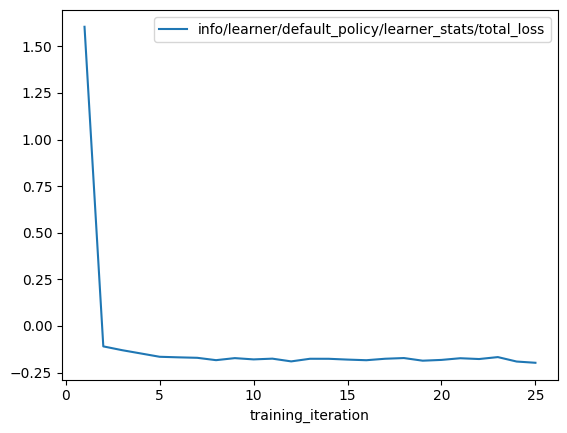

In [26]:
best_result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss")

<Axes: xlabel='training_iteration'>

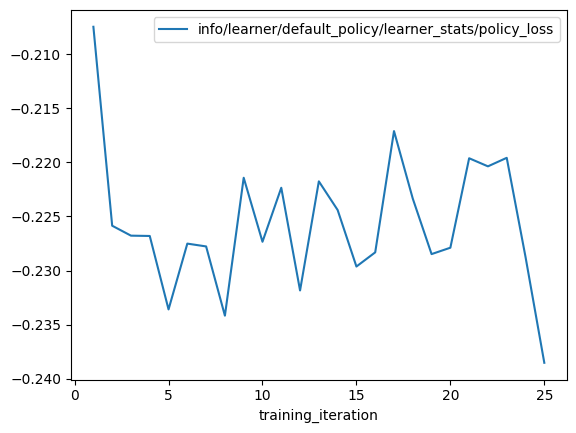

In [27]:
best_result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss")

<Axes: xlabel='training_iteration'>

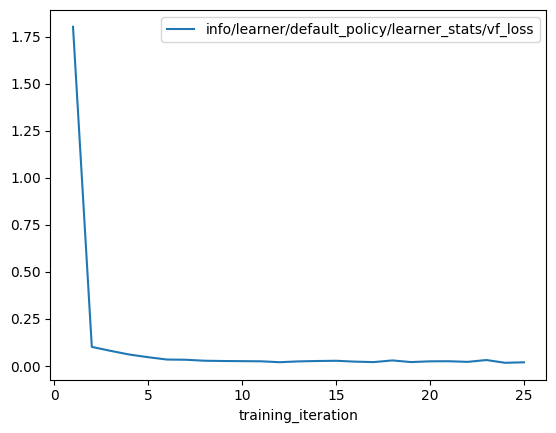

In [28]:
best_result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss")

<Axes: xlabel='training_iteration'>

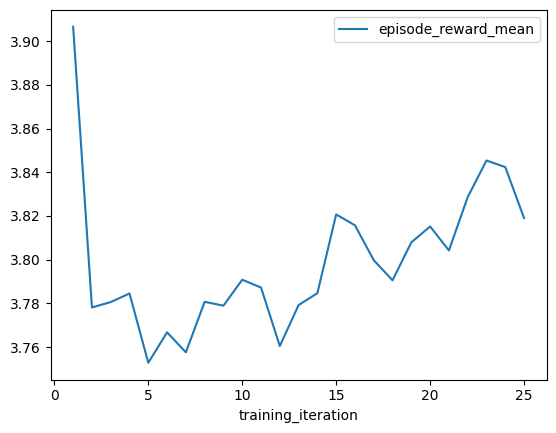

In [29]:
best_result.metrics_dataframe.plot("training_iteration", "episode_reward_mean")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

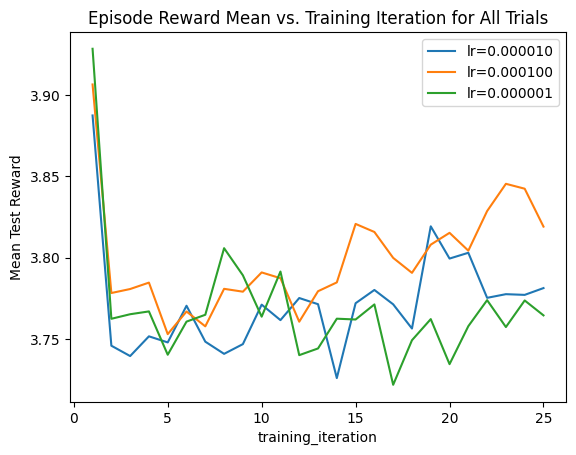

In [31]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Total Loss')

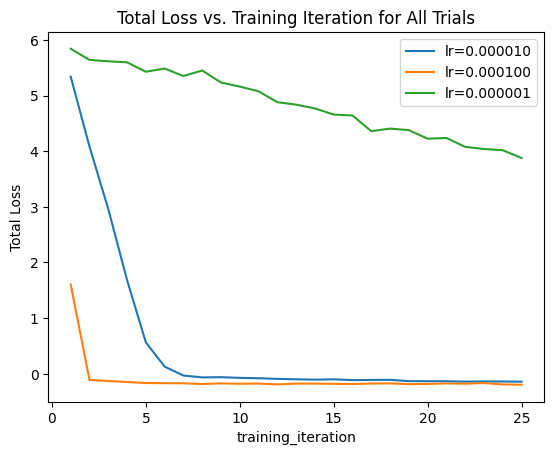

In [12]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", ax=ax, label=label)
ax.set_title("Total Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Total Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Policy Loss')

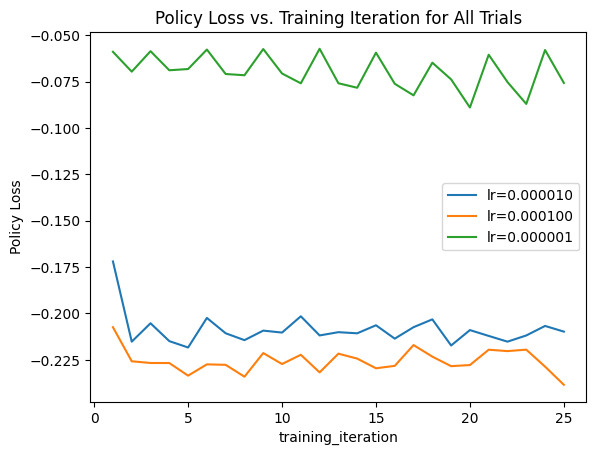

In [13]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", ax=ax, label=label)
ax.set_title("Policy Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Policy Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Value Function Loss')

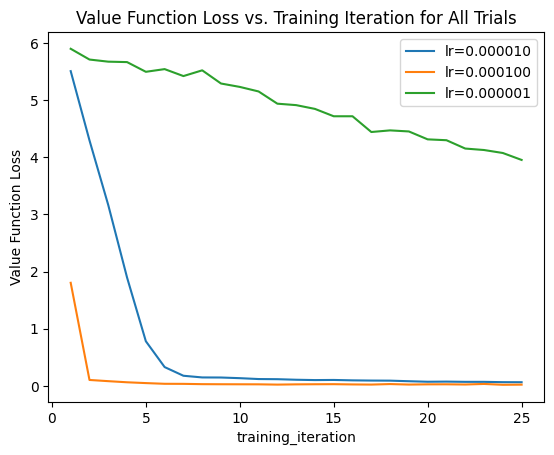

In [14]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", ax=ax, label=label)
ax.set_title("Value Function Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Value Function Loss")

entropy_coeff=0.1, lr=[1e-4, 1e-5, 1e-6]

In [14]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO2_entr_0_1 ...


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

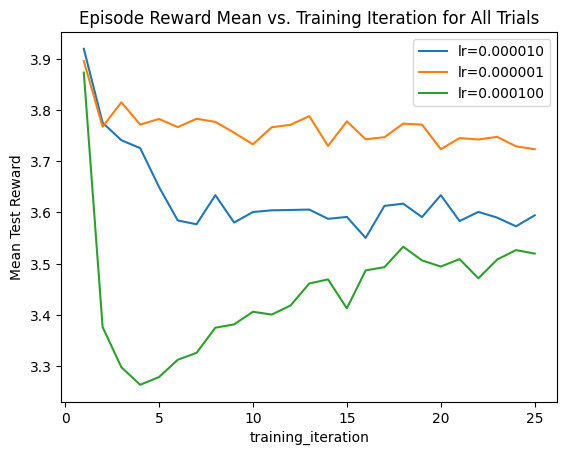

In [15]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Total Loss')

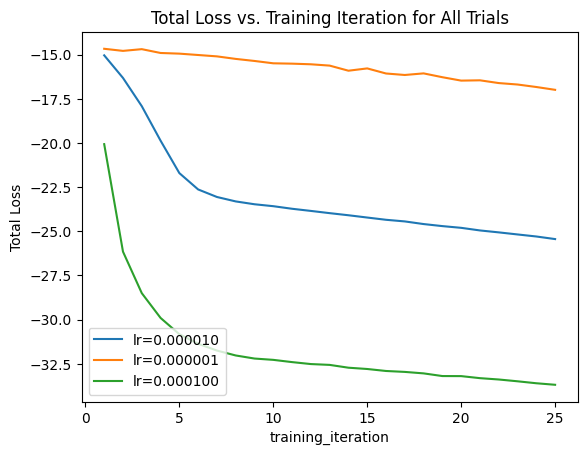

In [16]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", ax=ax, label=label)
ax.set_title("Total Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Total Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Policy Loss')

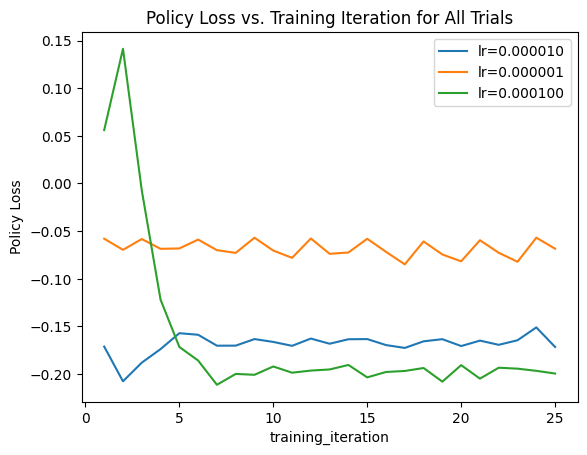

In [17]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", ax=ax, label=label)
ax.set_title("Policy Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Policy Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Value Function Loss')

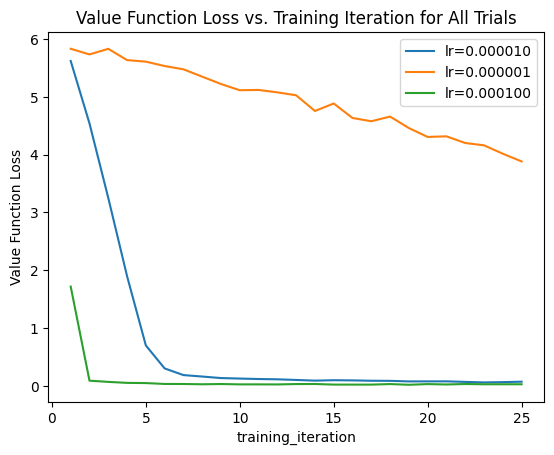

In [18]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", ax=ax, label=label)
ax.set_title("Value Function Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Value Function Loss")

entropy_coeff=0.01, lr=[1e-4, 1e-5, 1e-6]

In [14]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO2_entr_0_01 ...


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

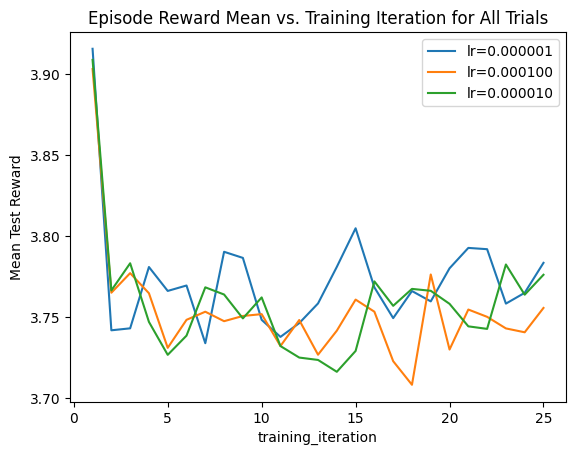

In [15]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Total Loss')

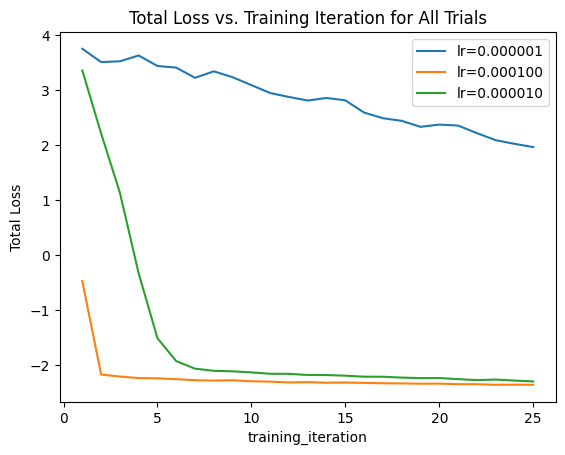

In [16]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", ax=ax, label=label)
ax.set_title("Total Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Total Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Policy Loss')

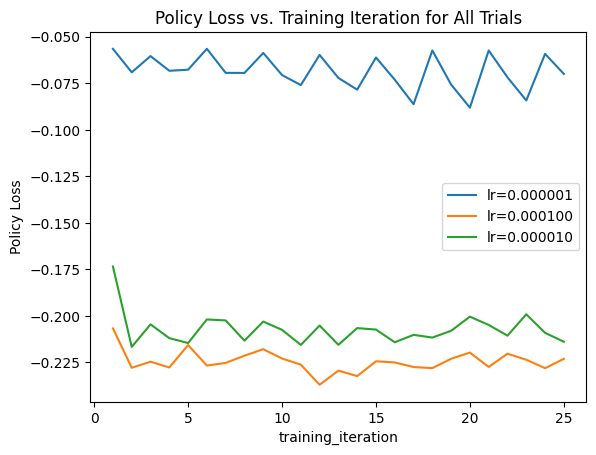

In [17]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", ax=ax, label=label)
ax.set_title("Policy Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Policy Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Value Function Loss')

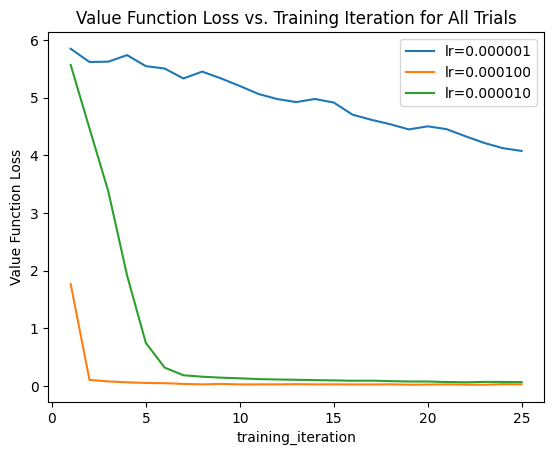

In [18]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", ax=ax, label=label)
ax.set_title("Value Function Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Value Function Loss")

entropy_coeff=0.1, lr=[0.01, 0.001, 0.0001]

In [14]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO3_entr_0_1 ...


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

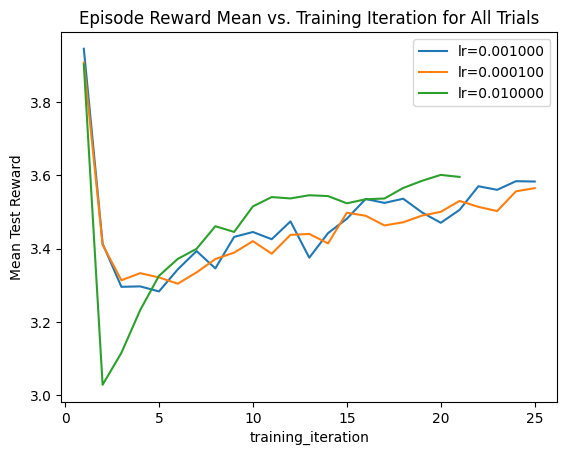

In [15]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Total Loss')

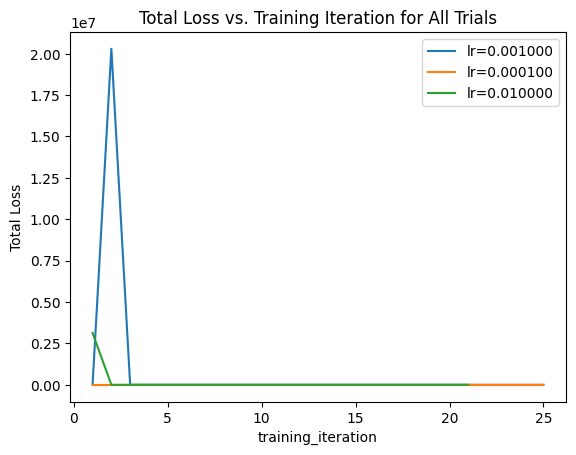

In [20]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", ax=ax, label=label)
ax.set_title("Total Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Total Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Policy Loss')

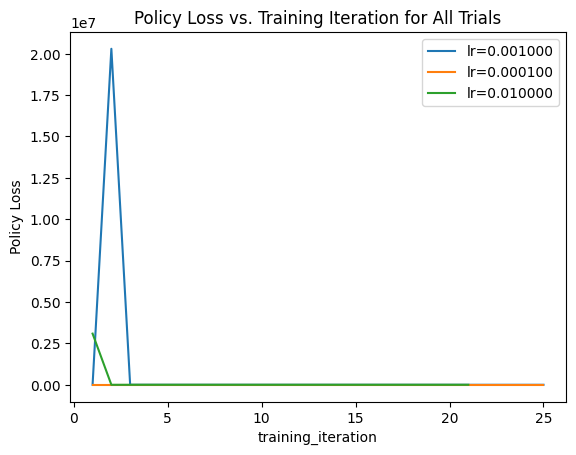

In [17]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", ax=ax, label=label)
ax.set_title("Policy Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Policy Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Value Function Loss')

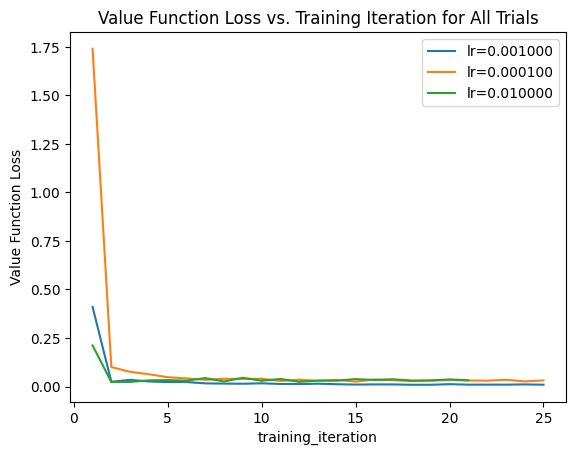

In [18]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", ax=ax, label=label)
ax.set_title("Value Function Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Value Function Loss")

epoch=200, lr=0.0001, entropy_coeff=0.1

In [11]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_e_500 ...


Text(0, 0.5, 'Mean Test Reward')

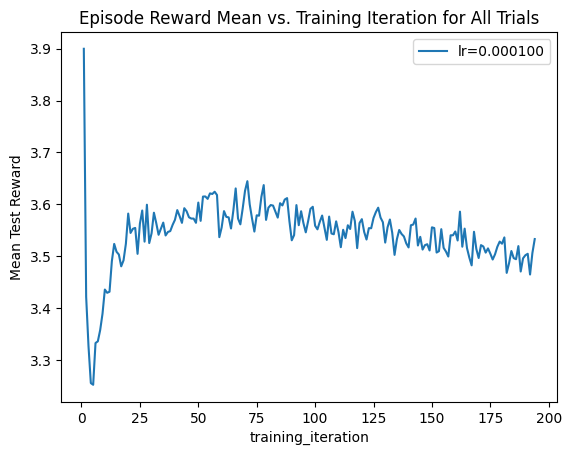

In [12]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

Text(0, 0.5, 'Total Loss')

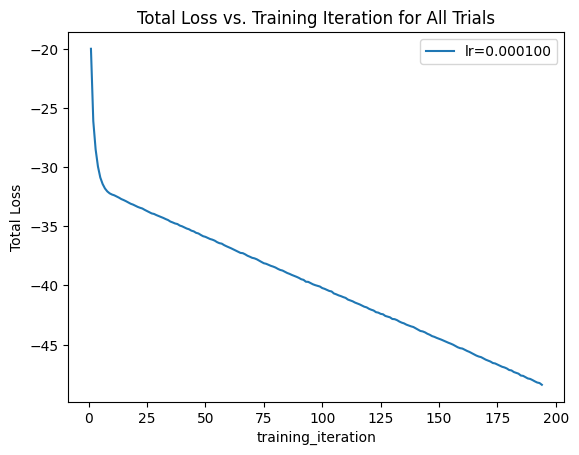

In [13]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/total_loss", ax=ax, label=label)
ax.set_title("Total Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Total Loss")

Text(0, 0.5, 'Policy Loss')

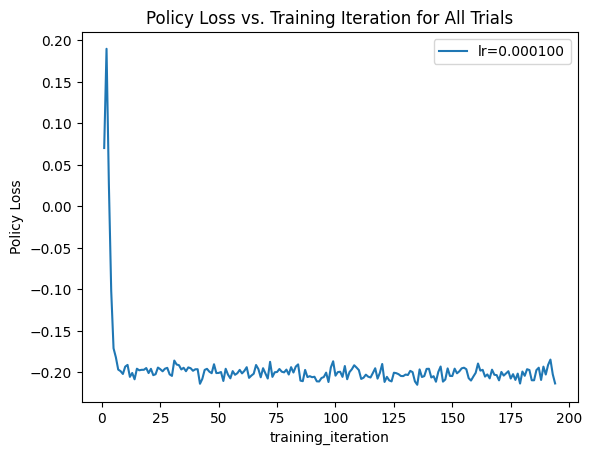

In [14]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/policy_loss", ax=ax, label=label)
ax.set_title("Policy Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Policy Loss")

Text(0, 0.5, 'Value Function Loss')

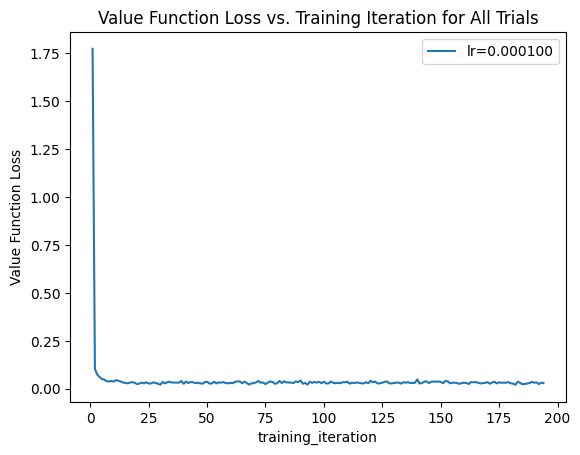

In [15]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/vf_loss", ax=ax, label=label)
ax.set_title("Value Function Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Value Function Loss")

lr=0.0001, entropy_coeff=0.1, lr_schedule=[[200000, 0.0001], [400000, 0.0001]]

In [13]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_e_200 ...


Text(0, 0.5, 'Mean Test Reward')

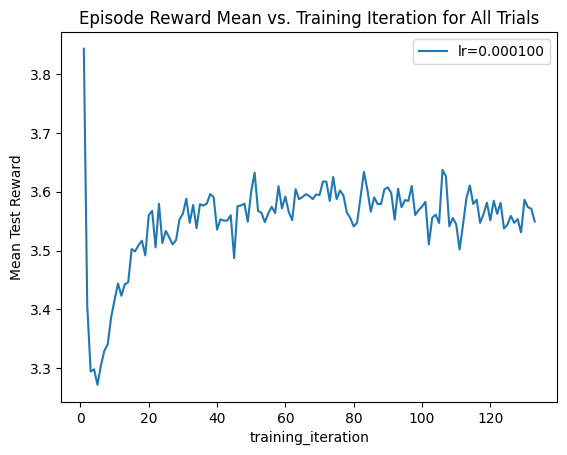

In [14]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

lr=0.0005, entropy_coeff=0.1

In [14]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="PPO")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_lr_0_0005 ...


Text(0, 0.5, 'Mean Test Reward')

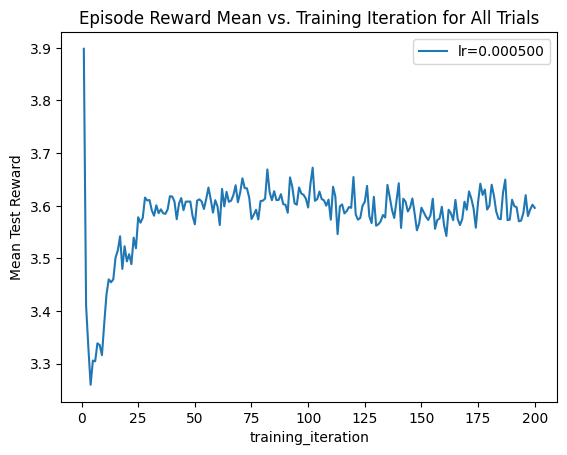

In [15]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")